In [1]:
import astropy.io.ascii as ascii
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import astropy.visualization as viz
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import astropy.wcs as WCS # you need this astropy module for processing fits files
import matplotlib as mpl
import numpy as np
from tqdm import tqdm
from astropy.table import Table, join
%matplotlib inline
from scipy.ndimage import interpolation
from skimage.transform import rescale, resize, downscale_local_mean
import h5py

Memory map in the 250K images and partially transpose them to group images together.

In [3]:
data = np.load('/home/thouis/xorastro/big-data/imgcube-uint8-all.npy', mmap_mode='r')
h5 = h5py.File('imgcube.h5', 'w')
chunked = h5.create_dataset('imgcube', shape=data.shape, dtype=data.dtype, chunks=(data.shape[0], data.shape[1], 1024), compression='lzf')

num_images = data.shape[2]
for idx in tqdm(range(0, num_images, 1024)):
    end = min(idx + 1024, num_images)
    chunked[:, :, idx:end] = data[:, :, idx:end]
h5.close()

100%|██████████| 242/242 [44:32<00:00,  1.05it/s]   


Now complete the transposition to each image stored contiguously.

In [13]:
h5 = h5py.File('imgcube.h5', 'r')
data = h5['imgcube']
h5new = h5py.File('imgcube2.h5', 'w')
chunked = h5new.create_dataset('imgcube', shape=data.shape, dtype=data.dtype, chunks=(data.shape[0], data.shape[1], 1), compression='lzf')
num_images = data.shape[2]
for idx in tqdm(range(0, num_images, 64)):
    end = min(idx + 64, num_images)
    chunked[:, :, idx:end] = data[:, :, idx:end]
h5.close()
h5new.close()


  0%|          | 7/3869 [00:03<30:57,  2.08it/s]

100%|██████████| 3869/3869 [38:25<00:00,  2.08it/s]


The rotation and viewpoint extraction will be done in the TF network.

In [1]:
import h5py
d = h5py.File('big-data/imgcube-uint8-all.h5')['imgcube']
d.shape

(424, 424, 247590)

In [4]:
from astropy.table import Table
metadata = Table.read('/home/thouis/xorastro/big-data/joined_meta.tsv', format='ascii.tab')
color = np.array(metadata[:]['g'] - metadata[:]['i'])


In [5]:
color.shape

(247590,)

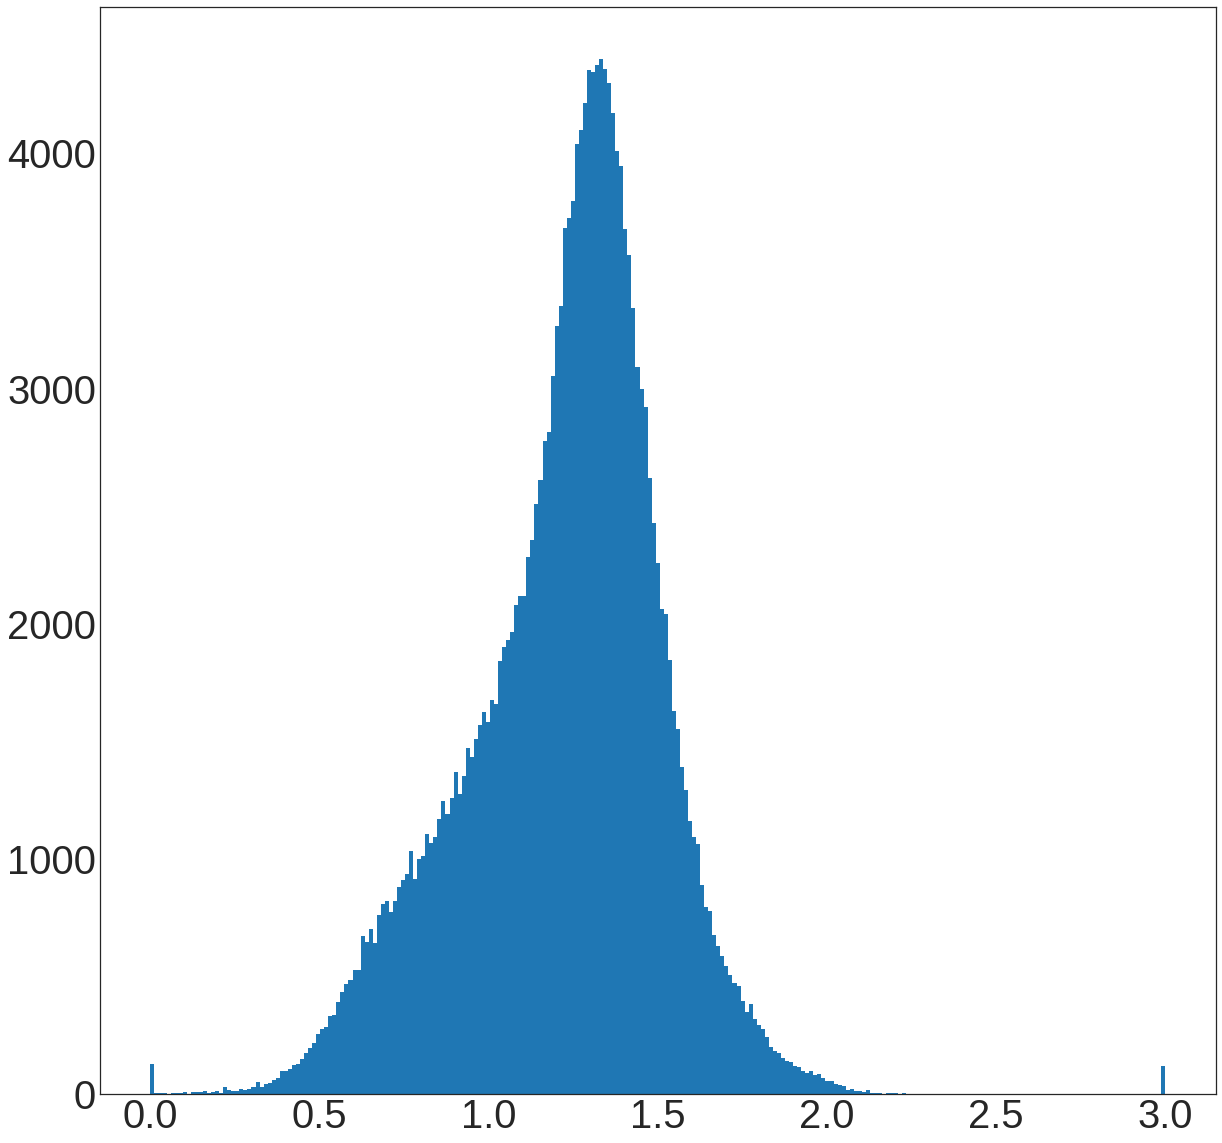

In [10]:
hist(np.clip(color[:int(247590* 0.8)], 0, 3), 'auto');


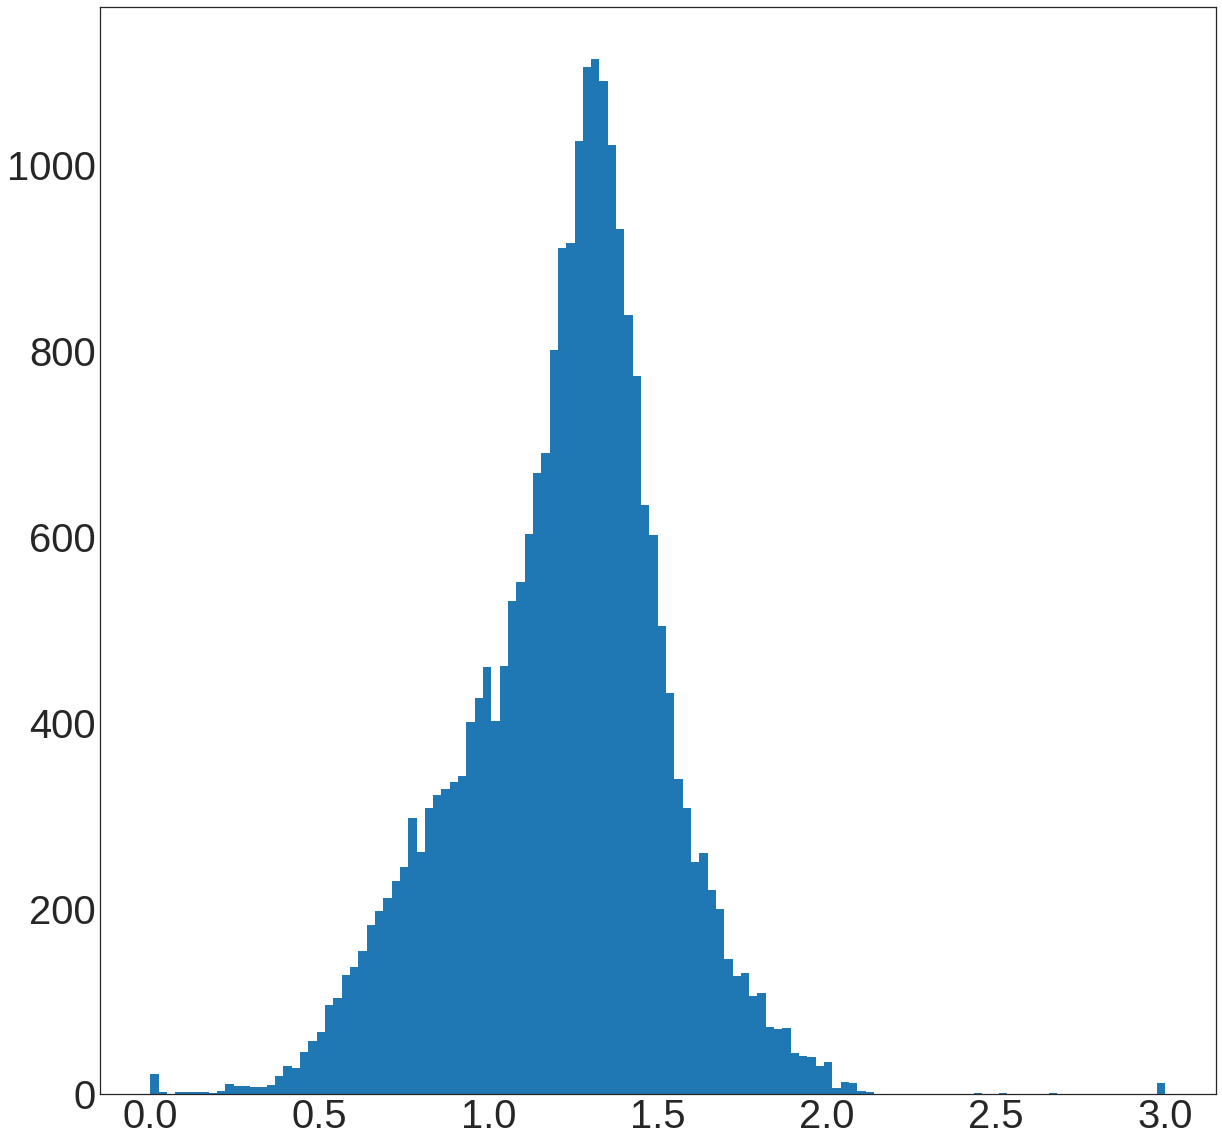

In [11]:
hist(np.clip(color[int(247590* 0.8):int(247590* 0.9)], 0, 3), 'auto');

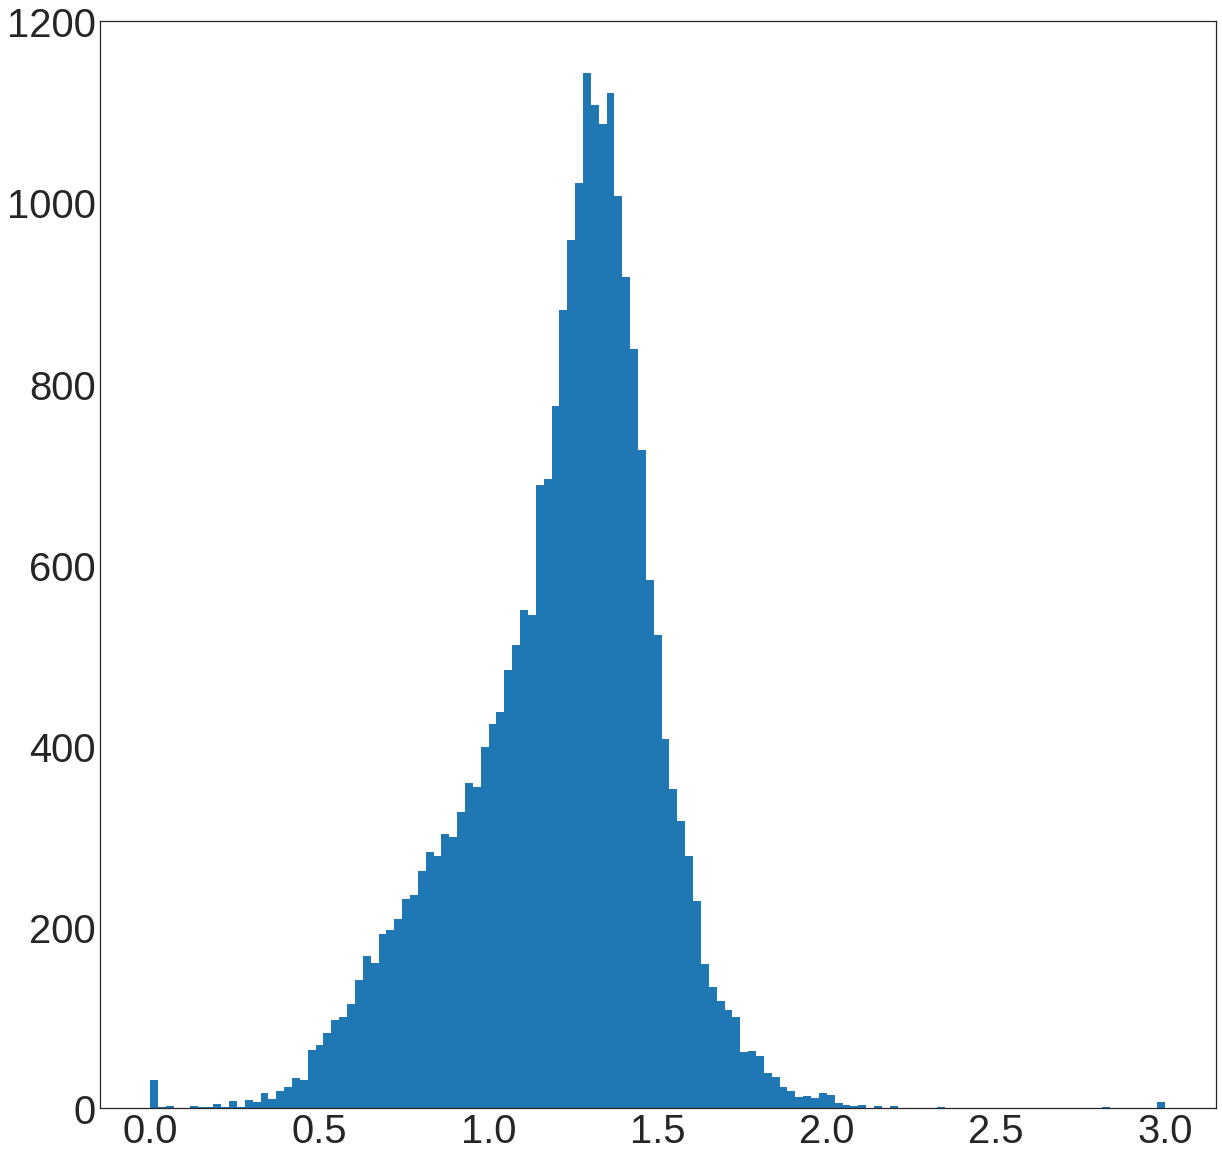

In [12]:
hist(np.clip(color[int(247590* 0.9):], 0, 3), 'auto');